In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
from numpy.ma.core import shape

warnings.filterwarnings("ignore", module="scipy")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


In [2]:
RANDOM_SEED = 8924
az.style.use("arviz-darkgrid")

In [3]:
try:
    srrs2 = pd.read_csv(os.path.join("..", "data", "srrs2.dat"))
except FileNotFoundError:
    srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))

srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

In [4]:
try:
    cty = pd.read_csv(os.path.join("..", "data", "cty.dat"))
except FileNotFoundError:
    cty = pd.read_csv(pm.get_data("cty.dat"))

srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

In [5]:
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

In [6]:
srrs_mn.county = srrs_mn.county.map(str.strip)
county, mn_counties = srrs_mn.county.factorize()
srrs_mn["county_code"] = county
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

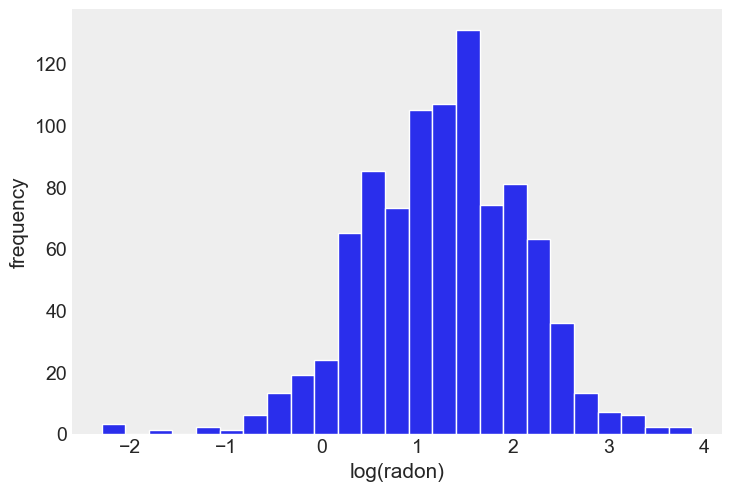

In [7]:
srrs_mn.log_radon.hist(bins=25, grid=False)
plt.xlabel("log(radon)")
plt.ylabel("frequency");

In [8]:
coords = {"county": mn_counties}

with pm.Model(coords=coords) as varying_intercept_slope:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1)

    mu_b = pm.Normal("mu_b", mu=0.0, sigma=10.0)
    sigma_b = pm.Exponential("sigma_b", 1)

    # Random intercepts
    alpha = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="county")
    # Random slopes
    beta = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims="county")

    # Model error
    sigma_y = pm.Exponential("sigma_y", 1)

    # Expected value
    y_hat = alpha[county_idx] + beta[county_idx] * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon, dims="obs_id")

F:\anaconda\envs\pymc_env\Lib\site-packages\pymc\data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [9]:
with varying_intercept_slope:
    varying_intercept_slope_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, alpha, beta, sigma_y]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 42 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


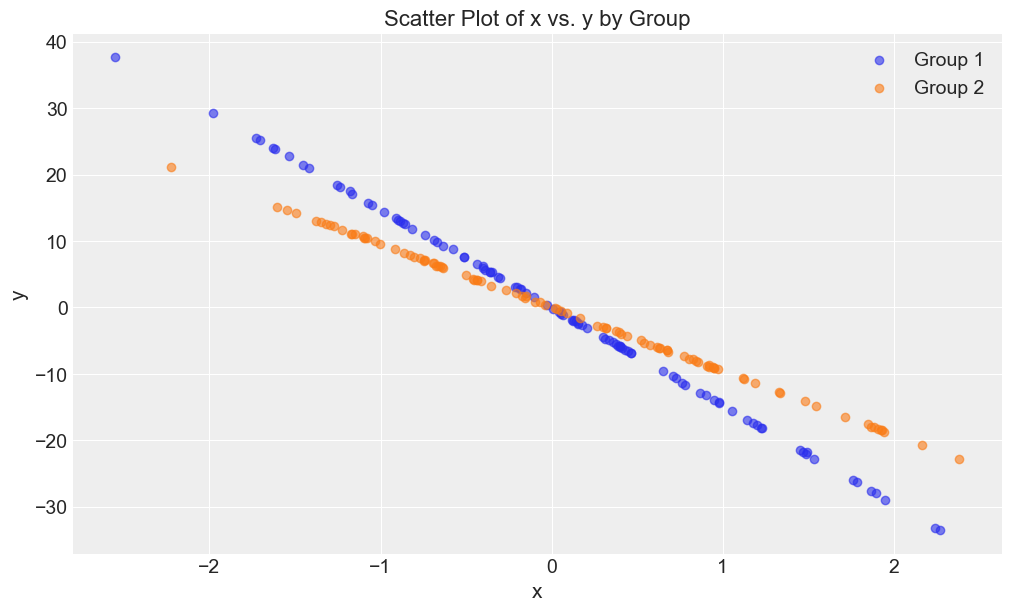

In [10]:
# Set random seed for reproducibility
np.random.seed(0)

# Number of samples and number of components
n_samples = 200
num_components = 2

# Generate the predictor variable x
x = np.random.normal(0, np.sqrt(1), n_samples)

# Initialize the response variable y
y = np.zeros(n_samples)

# Generate random betas (coefficients)
betas = np.random.normal(0, 40, num_components)

# Create group labels
groups = np.zeros(n_samples)

# Apply the different betas for every 100 samples and add random noise
for i in range(num_components):
    start_idx = i * 100
    end_idx = (i + 1) * 100
    y[start_idx:end_idx] = x[start_idx:end_idx] * betas[i] + np.random.normal(0, 0.1, 100)
    groups[start_idx:end_idx] = i

# Create a scatter plot, color-coded by group
plt.figure(figsize=(10, 6))
for i in range(num_components):
    group_idx = groups == i
    plt.scatter(x[group_idx], y[group_idx], label=f'Group {i+1}', alpha=0.6)

# Add plot labels and legend
plt.title('Scatter Plot of x vs. y by Group')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Plot the data
def stick_breaking(beta):
    portion_remaining = pt.concatenate([[1], pt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

# Gaussian Mixture Regression with GMR

In [2]:
import numpy as np
from gmr import GMM

# Your dataset as a NumPy array of shape (n_samples, n_features):
X = np.random.randn(100, 2)

gmm = GMM(n_components=3, random_state=0)
gmm.from_samples(X)

# Estimate GMM with expectation maximization:
X_sampled = gmm.sample(100)

# Make predictions with known values for the first feature:
x1 = np.random.randn(20, 1)
x1_index = [0]
x2_predicted_mean = gmm.predict(x1_index, x1)

<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\S'
<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\S'
<>:43: SyntaxWarning: invalid escape sequence '\m'
C:\Users\10191\AppData\Local\Temp\ipykernel_18556\211232875.py:25: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Linear: $p(Y | X) = \mathcal{N}(\mu_{Y|X}, \Sigma_{Y|X})$")
C:\Users\10191\AppData\Local\Temp\ipykernel_18556\211232875.py:42: SyntaxWarning: invalid escape sequence '\S'
  plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
C:\Users\10191\AppData\Local\Temp\ipykernel_18556\211232875.py:43: SyntaxWarning: invalid escape sequence '\m'
  "\mathcal{N}_{k, Y|X}$")


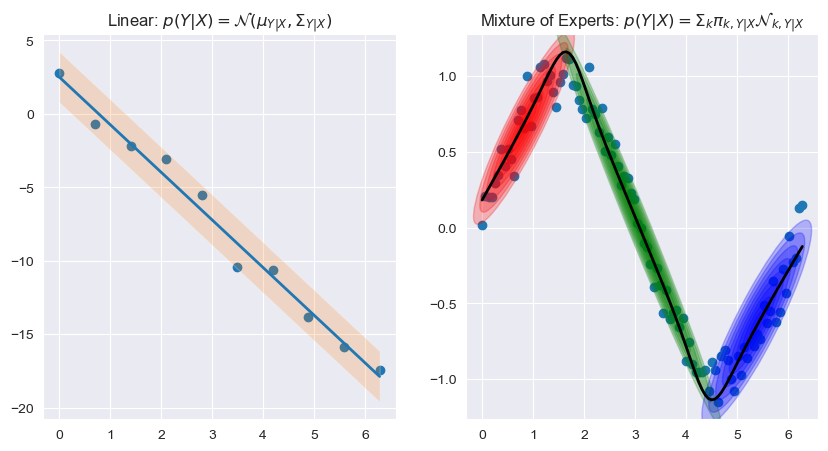

In [3]:
from sklearn.mixture import GaussianMixture
from gmr import GMM
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = 10
X = np.ndarray((n_samples, 2))
X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
X[:, 1] = 1 - 3 * X[:, 0] + random_state.randn(n_samples)

mvn = MVN(random_state=0)
mvn.from_samples(X)

X_test = np.linspace(0, 2 * np.pi, 100)
mean, covariance = mvn.predict(np.array([0]), X_test[:, np.newaxis])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Linear: $p(Y | X) = \mathcal{N}(\mu_{Y|X}, \Sigma_{Y|X})$")
plt.scatter(X[:, 0], X[:, 1])
y = mean.ravel()
s = 1.96 * np.sqrt(covariance.ravel())  # interval covers 95% of the data
plt.fill_between(X_test, y - s, y + s, alpha=0.2)
plt.plot(X_test, y, lw=2)

n_samples = 100
X = np.ndarray((n_samples, 2))
X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
X[:, 1] = np.sin(X[:, 0]) + random_state.randn(n_samples) * 0.1

gmm = GMM(n_components=3, random_state=0)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          "\mathcal{N}_{k, Y|X}$")
plt.scatter(X[:, 0], X[:, 1])
plot_error_ellipses(plt.gca(), gmm, colors=["r", "g", "b"])
plt.plot(X_test, Y.ravel(), c="k", lw=2)

plt.show()

# Bayesian Gaussian Mixture Regression with PyMC3

In [4]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr

In [5]:
n_samples = 100
random_state = np.random.RandomState(42)
X = np.ndarray((n_samples, 2))
X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
X[:, 1] = np.sin(X[:, 0]) + random_state.randn(n_samples) * 0.1

In [6]:
def stick_breaking(beta):
    portion_remaining = pt.concatenate([[1], pt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

N = X.shape[0]
K = 30

# Bayesian Mixtures of Linear Regression Models
Here we define the model $Y_{ij}=X_{ij}\beta_j + \epsilon$ 


In [51]:
df = pd.read_csv('mixture.csv')
X = df['X'].values[:, None]
Y = df['Y'].values
k = 2 

In [48]:
#Do not run this code
n_samples = 100
random_state = np.random.RandomState(42)
X = np.ndarray((n_samples, 2))
X = np.linspace(0, 2 * np.pi, n_samples)
Y = np.sin(X) + random_state.randn(n_samples) * 0.1
k = 2 
RANDOM_SEED = 42

In [ ]:
#Gaussian Mixture Model
with pm.Model() as Mixture_regression1:
    # Priors for weight parameter
    π = pm.Dirichlet('π', np.array([1]*k), testval=np.ones(k)/k)
    
    # Priors for unknown model parameters
    α = pm.Normal('α', mu=0, sigma=100, shape=(1, k)) #Intercept
    β = pm.Normal('β', mu=0, sigma=100, shape=(1, k))
    σ  = pm.HalfCauchy('σ', 5, shape=k)  #Noise
    
    mu = α + β*X
        
    likelihood = pm.NormalMixture('likelihood', π, mu, sigma=σ, observed=Y)
    trace = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

C:\Users\10191\AppData\Local\Temp\ipykernel_18556\225800188.py:4: FutureWarning: The `testval` argument is deprecated; use `initval`.
  π = pm.Dirichlet('π', np.array([1]*k), testval=np.ones(k)/k)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [π, α, β, σ]


In [17]:
# Still debugging for the following code
with pm.Model(coords={"component": np.arange(K), "obs_id": np.arange(N)}) as regression_model:
    # Stick-breaking process for component weights
    alpha = pm.Gamma("alpha", 1.0, 1.0)
    beta = pm.Beta("beta", 1.0, alpha, size=K)
    w = pm.Deterministic("w", stick_breaking(beta), dims="component")  # Component weights

    # Mixture components
    mu = pm.Normal("mu", 0, sigma=10, size=K)
    tau = pm.Gamma("tau", 1.0, 1.0, dims="component")
    lambda_ = pm.Gamma("lambda_", 10.0, 1.0, dims="component")
    # Priors for beta drawn from the Gaussian mixture model
    beta_y = pm.Normal("beta_y", mu=0, tau=tau*lambda_, dims="component")
    # Expected value  
    # Data likelihood  

In [29]:
RANDOM_SEED = 42
with regression_model:
    # Sampling from the posterior
    trace_regression = pm.sample(tune=2000, random_seed=RANDOM_SEED)
    
    # Posterior predictive check to get predictions
    posterior_predictive = pm.sample_posterior_predictive(trace_regression)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


ValueError: Shape mismatch: A.shape[1] != x.shape[0]
Apply node that caused the error: CGemv{no_inplace}(Y_obs{[ 4.967141 ... 87133e-02]}, -1.0, [[ 0.00000 ... 7133e-02]], beta_y, 1.0)
Toposort index: 2
Inputs types: [TensorType(float64, shape=(100,)), TensorType(float64, shape=()), TensorType(float64, shape=(100, 2)), TensorType(float64, shape=(None,)), TensorType(float64, shape=())]
Inputs shapes: [(100,), (), (100, 2), (100,), ()]
Inputs strides: [(8,), (), (16, 8), (8,), ()]
Inputs values: ['not shown', array(-1.), 'not shown', 'not shown', array(1.)]
Outputs clients: [[Composite{switch(i3, (((-0.5 * sqr((i0 / i1))) - 0.9189385332046727) - i2), -inf)}(CGemv{no_inplace}.0, ExpandDims{axis=0}.0, Log.0, Gt.0)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'beta_y'}>,
        <Axes: title={'center': 'beta_y'}>],
       [<Axes: title={'center': 'lambda_'}>,
        <Axes: title={'center': 'lambda_'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'mu_y'}>,
        <Axes: title={'center': 'mu_y'}>],
       [<Axes: title={'center': 'sigma_y'}>,
        <Axes: title={'center': 'sigma_y'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>]],
      dtype=object)

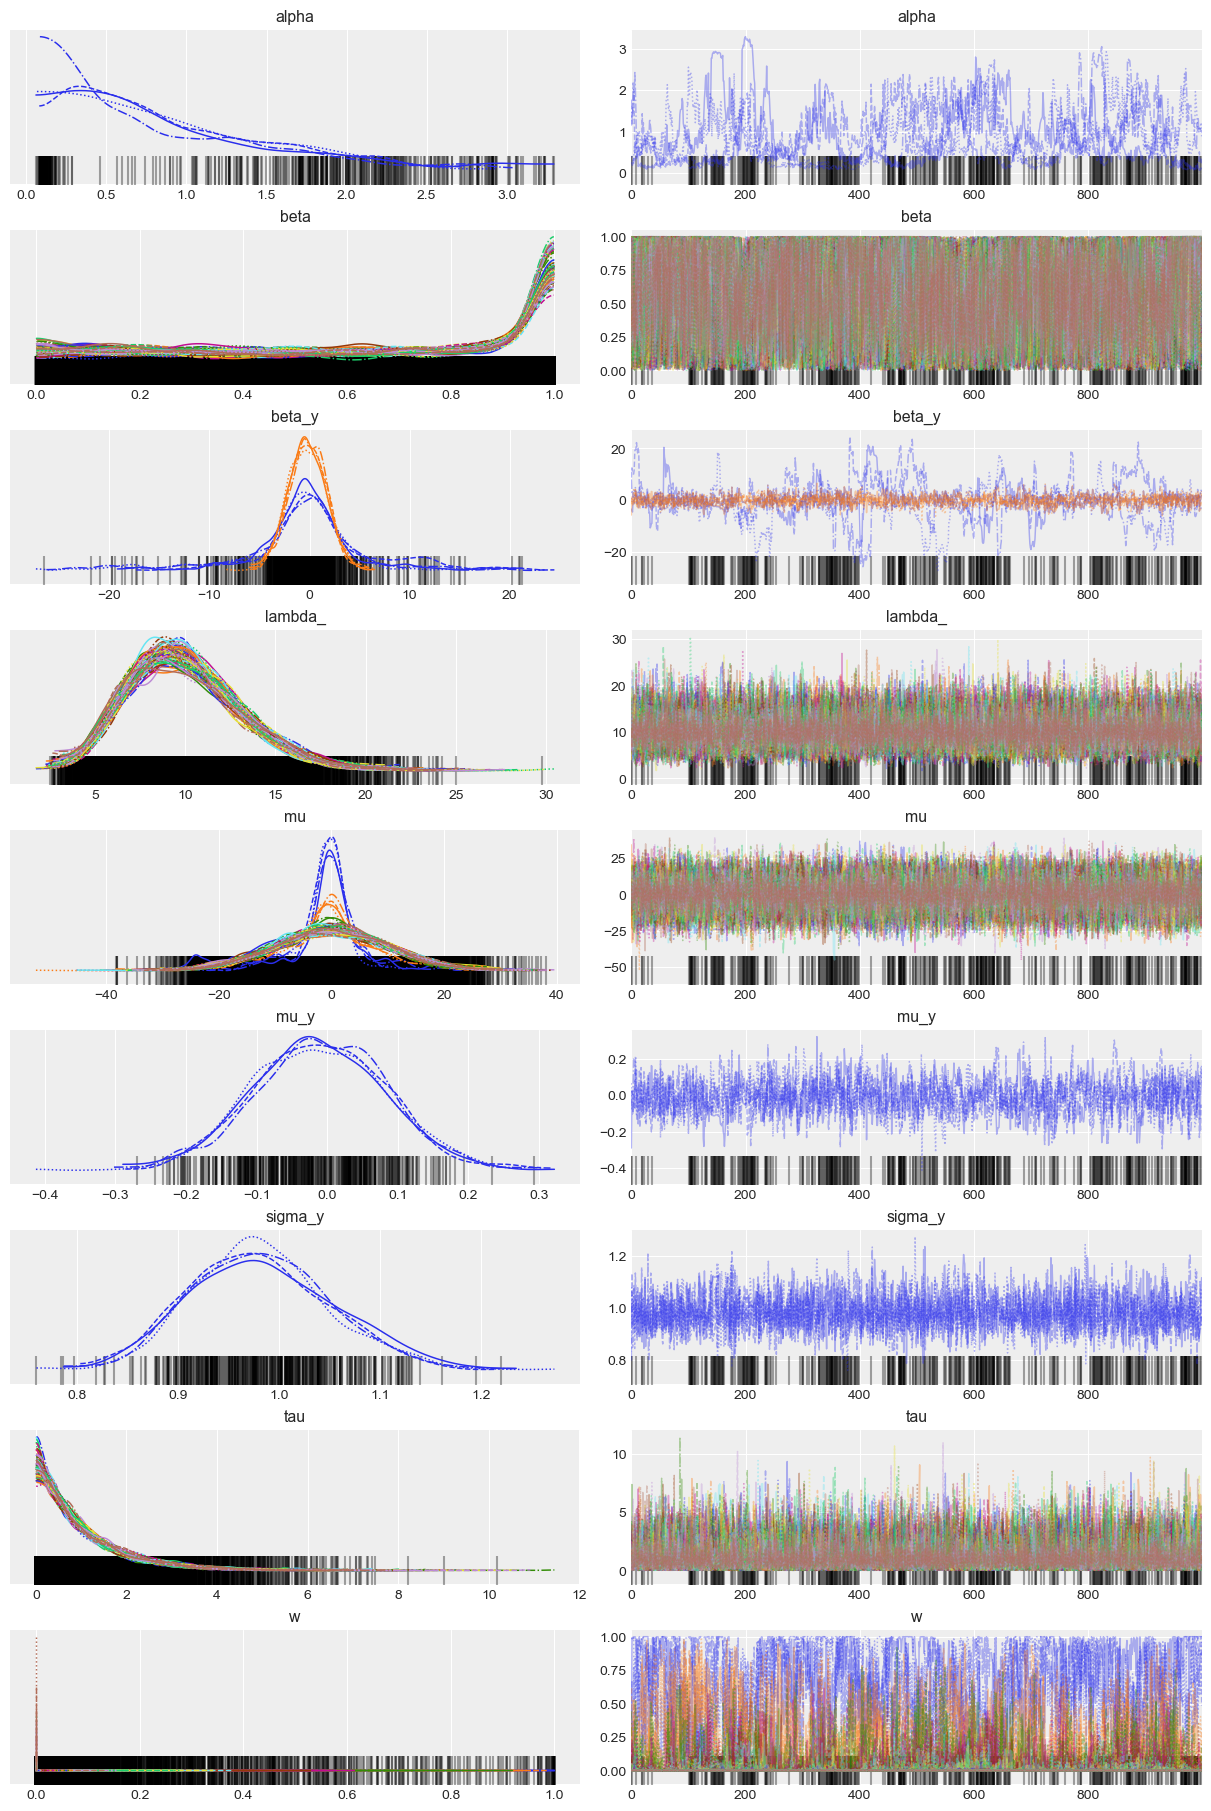

In [41]:
az.plot_trace(trace_regression)

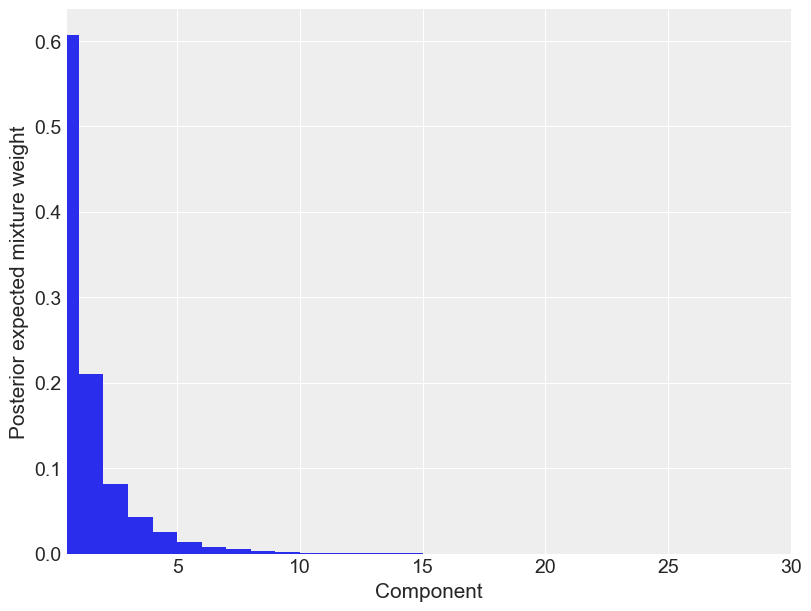

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace_regression.posterior["w"].mean(("chain", "draw")), width=1.0, lw=0)

ax.set_xlim(0.5, K)
ax.set_xlabel("Component")

ax.set_ylabel("Posterior expected mixture weight");